In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2

In [47]:
env = gym2.make('Linear-v0')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = 1.

In [78]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + np.dot(integral, action)
    
    return s_prime
    
    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    next_value_weight = 1
    
    taus = np.linspace(.01, 1., 100)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        ev = u**2 - l * tau + next_value_weight * np.dot(np.dot(s_prime, P), s_prime)
        #print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

def control_law2(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    
    taus = np.linspace(.01, 1., 100)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    AA_inv = np.linalg.inv(A+A.T)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu
        # int exp(At)dt
        integral1 = A_inv - np.dot(A_inv, array_exp(-A*tau))
        # int exp(A^Tt)exp(At)dt
        integral2 = AA_inv - np.dot(AA_inv, array_exp(-(A+A.T)*tau))

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state)) + 2 * np.dot(np.dot(state, integral2), np.dot(integral1, B))
        second = 2 * np.dot(np.dot(dsdu, P), integral) + 2 + 2 * np.dot(np.dot(integral1, B), np.dot(integral1, B))

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        
        tmp = state + np.dot(integral1, B) * u
        transition = np.dot(np.dot(tmp, integral2), tmp)
        ev = transition + u**2 - l * tau + np.dot(np.dot(s_prime, P), s_prime)
        print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [79]:
state = np.array([.1,.1])
control_law2(state, env)

[0.03690388 0.20746878] -0.010996229076812488 [0.008242204358714424, 0.01] 22.4787039452265
[0.03980985 0.20577221] -0.020869751281373916 [0.008785651074361042, 0.02] 22.159696703408187
[0.04269254 0.20422911] -0.030748305130927005 [0.009321060172941398, 0.03] 21.865531013858202
[0.04555885 0.20284082] -0.040630690461999276 [0.009846373592161768, 0.04] 21.596918805659225
[0.04841552 0.20160906] -0.0505156247723231 [0.010359263524965861, 0.05] 21.354670642516492
[0.05126905 0.20053587] -0.06040172642104774 [0.010857115033672423, 0.060000000000000005] 21.139704953636592
[0.05412565 0.19962354] -0.07028749761423292 [0.01133701101327088, 0.06999999999999999] 20.953058234536933
[0.05699117 0.19887454] -0.08017130786298335 [0.011795720497271234, 0.08] 20.79589631895106
[0.05987094 0.19829143] -0.09005137893486355 [0.012229691416087929, 0.09] 20.66952683362487
[0.0627697 0.1978767] -0.09992577274670472 [0.012635049004827037, 0.09999999999999999] 20.575412959544366
[0.06569141 0.19763269] -0.1

array([-0.01223223,  0.41      ])

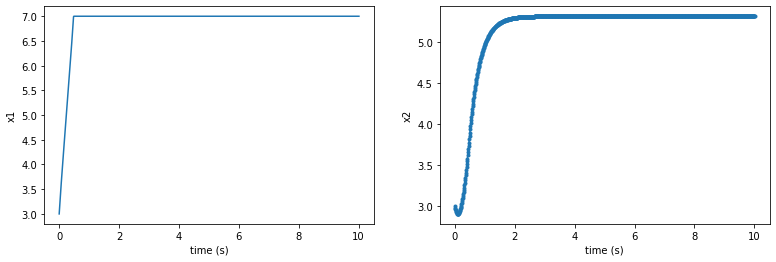

CPU times: user 3min 34s, sys: 29.8 s, total: 4min 4s
Wall time: 1min 35s


In [74]:
%%time

l = .1
env.reset()
i_state = np.array([3,3])
env.set_state(i_state)
states = []
time_limit = 10
time_log = [0]
actions = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([x[0], x[1]])
    a_agent, tau = control_law2(x, env, l=l)
    #print(a_agent, tau)
    actions.append([a_agent, tau])
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states.append(env.state)
actions.append(control_law2(env.state, env, l=l))
states = np.array(states)
actions = np.array(actions)

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.xlabel('time (s)')
plt.ylabel('x1')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('time (s)')
plt.ylabel('x2')
plt.plot(time_log, states[:,1])
plt.scatter(time_log, states[:,1], marker='.')
plt.show()

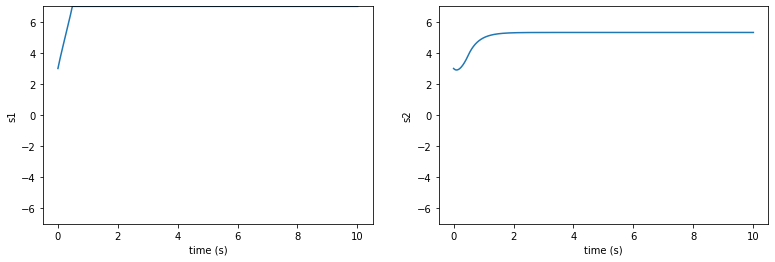

In [75]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.ylim(-7,7)
plt.xlabel('time (s)')
plt.ylabel('s1')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.ylim(-7,7)
plt.xlabel('time (s)')
plt.ylabel('s2')
plt.plot(time_log, states[:,1])

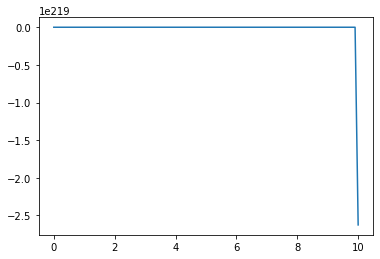

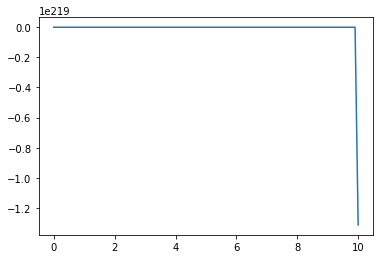

In [71]:
# unstable
u = 0
taus = np.linspace(0,10,100)
states = []
ss = 7 * np.random.uniform(low=[-1,-1], high=[1,1])
for tau in taus:
    ss = next_state(ss, u, tau, env)
    states.append(ss)
states = np.array(states)
plt.plot(taus, states[:,0])
plt.show()
plt.plot(taus, states[:,1])
plt.show()